# Renewable Potential Validation

##  Objectives

In this notebook, we will focus on several key objectives:

1. **Calculate Technical Resource Potential**: We aim to determine the technical resource potential for solar and wind energy in Zambia. To validate this potential, we will compare our calculations with publicly available data.

2. **Validate Technical Installable Potential**: To validate the technical installable potential, we will compare the capacity factors for wind and solar energy obtained using the PyPSA tool with data from Renewable Ninja, an external resource.

3. **Calculate Technical Installable Potential**: We will calculate the technical installable potential for wind and solar energy in gigawatts (GW), providing us with an estimate of the maximum capacity that can be installed.

4. **Plot Capacity Factors**: We will create plots showing the capacity factors for wind and solar energy for the year 2013. These factors represent the efficiency of energy generation.

5. **Create Maps**: Lastly, we will generate maps that illustrate the potential for wind and solar energy in different regions of Zambia.

Through these analyses and visualizations, we aim to better understand and quantify the renewable energy potential in Zambia while validating our findings against established data sources.


## Generate profiles (if not already available)
If you don't have the renewable profiles such as:
- `resources/profile_renewables/profile_solar.nc`
- `resources/profile_renewables/profile_onwind.nc`
- `resources/profile_renewables/profile_offwind-ac.nc`

you could try to generate them from the terminal. In this case set the path so that you are located at ~/pypsa-earth. Once you are there, use the command:

```
snakemake -j 1 resources/profile_{technology}.nc
```

replace {technology} for the timeseries of interest.

## Preparation


In [ ]:
import atlite
import cartopy.crs as ccrs
import xarray as xr
import geopandas as gpd
import cartopy
# import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer


plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

In [99]:
solar_path='C:\\Users\\user\\Desktop\\pypsa-earth\\resources\\renewable_profiles\\profile_solar.nc'
solar=xr.open_dataset(solar_path)
solar
wind_path='C:\\Users\\user\\Desktop\\pypsa-earth\\resources\\renewable_profiles\\profile_onwind.nc'
wind=xr.open_dataset(wind_path)
wind

<xarray.Dataset>
Dimensions:           (time: 8760, bus: 135, y: 35, x: 41)
Coordinates:
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
  * bus               (bus) object '0' '3' '5' '8' ... '169' '170' '171' '172'
  * y                 (y) float64 -18.3 -18.0 -17.7 -17.4 ... -8.7 -8.4 -8.1
  * x                 (x) float64 21.9 22.2 22.5 22.8 ... 33.0 33.3 33.6 33.9
Data variables:
    profile           (time, bus) float64 ...
    weight            (bus) float64 ...
    p_nom_max         (bus) float64 ...
    potential         (y, x) float64 ...
    average_distance  (bus) float64 ...

## Technical Resource Energy Potential 


The technical resource energy potential refers to the amount of renewable energy that can be harnessed from a specific area, taking into account various factors like land suitability, shading, and technical limitations. In the PyPSA Earth model, this potential is calculated through a series of steps:

1. **Identifying Suitable Land**: We begin by identifying the land area within which renewable energy can be developed. This information is typically derived from geospatial data, including land cover maps.

2. **Excluding Unsuitable Areas**: Areas unsuitable for renewable energy, such as protected zones, urban areas, or areas with steep terrain, are excluded from consideration.

3. **Evaluating Shading**: We assess the shading factor for the remaining land, taking into account factors like tree cover, buildings, or other objects that may cast shadows. This evaluation can be based on satellite imagery or on-ground measurements.

4. **Considering Technical Constraints**: To incorporate technical constraints, historical data on the performance and availability of renewable energy systems are considered.

5. **Calculating the Potential**: The technical resource energy potential is calculated using the following formula:   Technical resource energy potential = (Total Available Area × Renewable Energy Capacity Factor) × (1 - Shading Factor) × (1 - Technical Constraint Factor)


- `Total Available Area` is the land area available for renewable energy development.
- `Renewable Energy Capacity Factor` represents the percentage of time when the renewable energy system is expected to generate electricity at its rated capacity.
- `Shading Factor` indicates the portion of the renewable energy system that is likely to be shaded by various objects.
- `Technical Constraint Factor` considers any technical limitations that affect energy generation.

This comprehensive calculation helps us estimate the potential renewable energy generation from a specific area while accounting for various real-world factors.

All the steps above are done for us by the workflow. The code below shows how we can access or find the resource potential in the pypsa earth model.


   


In [100]:
technical_solar_potential_twh = (
    sum(solar["p_nom_max"] * solar["profile"]).sum() / 10**6
)  # MWh to TWH conversion
technical_wind_potential_twh = (
    sum(wind["p_nom_max"] * wind["profile"]).sum() / 10**6
)  # MWh to TWH conversion

print(
    "Socio-technical solar potential for Zambia with exclusion area - PyPSA:",
    technical_solar_potential_twh.values.round(),
    "TWh",
)
print(
    "Socio-technical wind potential for Zambia with exclusion area - PyPSA:",
    technical_wind_potential_twh.values.round(),
    "TWh",
)

print(
    "Comparing with the below values. Wind seems ok and solar seems low. Important is that PyPSA is mentioning the socio-technical wind potential which is assumed to be between 5-10% of the technical potential. More discussion are given here: https://github.com/pypsa-meets-africa/pypsa-earth/issues/361"
)

Socio-technical solar potential for Zambia with exclusion area - PyPSA: 960.0 TWh
Socio-technical wind potential for Zambia with exclusion area - PyPSA: 997.0 TWh
Comparing with the below values. Wind seems ok and solar seems low. Important is that PyPSA is mentioning the socio-technical wind potential which is assumed to be between 5-10% of the technical potential. More discussion are given here: https://github.com/pypsa-meets-africa/pypsa-earth/issues/361


## Technical Installable Potential in GW
The technical installable potential for wind and solar is the amount of wind and solar power that can be installed in a given area, taking into account factors such as land availability, shading, and technical constraints. It is different from the theoretical potential, which is the maximum amount of wind and solar power that could be generated in a given area if there were no constraints.

### Loading the solved network

In [172]:
n=pypsa.Network("C:\\Users\\user\\Desktop\\pypsa-earth\\results\\networks\\elec_s_10_ec_lcopt_Co2L-12H.nc")


INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-12H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Calculating the technical installable potential for solar

In [173]:
solar_installable_potential=int(n.generators.p_nom_max[n.generators.carrier=='solar'].sum()/1000 )# GW
print(" The technical installable potential for solar is {} GW".format(round(solar_installable_potential)))

 The technical installable potential for solar is 651 GW


### Calculating the technical installable potential for wind

In [174]:
onwind_installable_potential=int(n.generators.p_nom_max[n.generators.carrier=='onwind'].sum()/1000 )# GW
print(" The technical installable potential for wind is {} GW".format(round(onwind_installable_potential)))

 The technical installable potential for wind is 1045 GW


## Capacity Factor Validation for Solar and Wind
The capacity factor for solar and wind is the percentage of time that a solar or wind power plant is expected to generate electricity at its rated capacity. It is a measure of how reliably a solar or wind power plant can generate electricity.

The capacity factor for solar and wind is typically lower than the capacity factor for fossil fuel power plants, because solar and wind power plants are dependent on the availability of sunlight and wind. However, the capacity factor for solar and wind is increasing as solar and wind technologies improve.

The capacity factor for solar and wind can be calculated using the following formula:

Capacity factor = (Actual energy generated) / (Maximum possible energy generated)

Where:

Actual energy generated is the amount of electricity that a solar or wind power plant actually generates over a given period of time.
Maximum possible energy generated is the amount of electricity that a solar or wind power plant could generate if it were operating at its rated capacity for the entire period of time.
The capacity factor for solar and wind can vary depending on a number of factors, including the location of the power plant, the time of year, and the weather conditions. For example, the capacity factor for solar and wind power plants is typically higher in the summer months than in the winter months, because there is more sunlight and wind in the summer.

The capacity factor for solar and wind is an important factor to consider when assessing the potential of solar and wind power to meet an electricity demand. For example, if a solar or wind power plant has a capacity factor of 30%, then it can be expected to generate electricity for 30% of the time. This means that other power sources, such as fossil fuel power plants, will need to be used to meet the electricity demand for the remaining 70% of the time.

Despite their lower capacity factors, solar and wind power are becoming increasingly important sources of electricity generation, as they are clean and renewable sources of energy.

### Mean solar Capacity Factor for all the 10 nodes

In [176]:
# Explanation of Code: Calculating Mean Capacity Factor for Multiple Nodes

'''The following code snippet demonstrates a procedure to calculate the mean capacity factor for solar energy across multiple nodes. The code iterates through ten nodes, calculates the mean capacity factor for each node, and then computes the average capacity factor for all ten nodes.

'''
capacity_fac_list = []

for node in range(10):
    # Calculate the mean capacity factor for the current node
    n_cp = n.generators_t.p_max_pu[n.generators.index[n.generators.carrier=='solar']]["ZM0 {} solar".format(node)].resample('M').mean().mean()
    # Append the result to the capacity_fac_list
    capacity_fac_list.append(n_cp)

# Calculate the average capacity factor for all ten nodes
mean_capacity_factor_for_allNodes = sum(capacity_fac_list) / 10
mean_capacity_factor_for_allNodes 

0.16754389501378714

### Mean wind Capacity Factor for all the 10 nodes

In [180]:
capacity_fac_list=[]

for node in range(10):
    n_cp=n.generators_t.p_max_pu[n.generators.index[n.generators.carrier=='onwind']]["ZM0 {} onwind".format(node)].resample('M').mean().mean()
    capacity_fac_list.append(n_cp)
mean_capacity_factor_for_allNodes=sum(capacity_fac_list)/10
mean_capacity_factor_for_allNodes


0.11168108306175746

### Plotting solar and wind Capacity Factors

#### Plots of the solar capacity factors for all the 10 nodes

<AxesSubplot:xlabel='snapshot'>

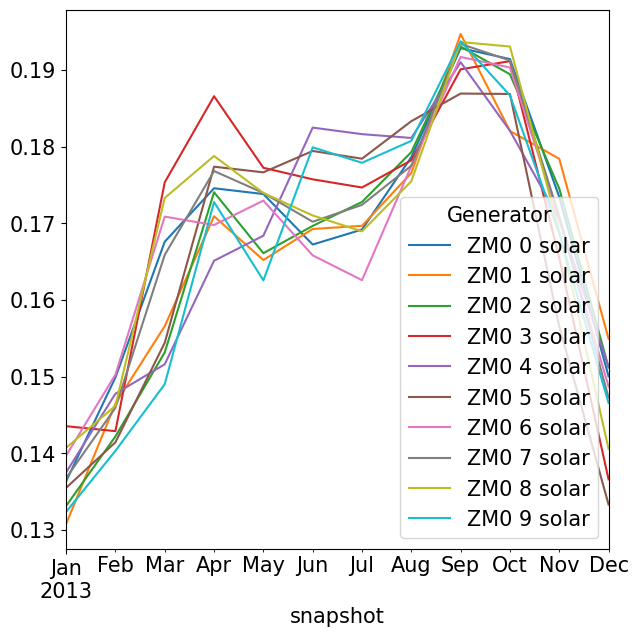

In [181]:
n.generators_t.p_max_pu[n.generators.index[n.generators.carrier=='solar']].resample("M").mean().plot()

#### Plots of the wind capacity factors for all the 10 nodes

<AxesSubplot:xlabel='snapshot'>

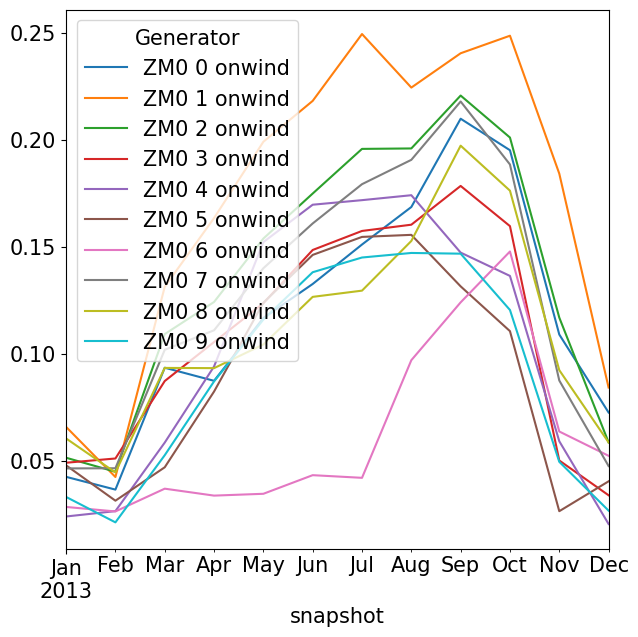

In [182]:
n.generators_t.p_max_pu[n.generators.index[n.generators.carrier=='onwind']].resample("M").mean().plot()

### Renewable Ninja Data
For the renewable potential validation, we considered Renewable Ninja as our external source. from the Renewable Ninja website, we were able to calculate the mean capacity factor for the year 2013 for both solar and wind. We also managed to get plots of the capacity factors for wind and solar. The capacity factor for solar was found to be 16.2% and  the capacity factor for wind was found to be 11.9% . The figures below shows the capacity factors and their corresponding plots for both solar and wind.

#### capacity factor for wind

![mean capacity factor for solar](onwindcapacityfactor.png)

#### capacity factor for solar

![mean capacity factor for solar](solarcf.png)



### Comments
The capacity factor for solar in PyPSA Earth is 16.75%, whereas the capacity factor for solar from the Renewable Ninja website is 16.2%. Similarly, the capacity factor for wind in the workflow is 11.17%, while the capacity factor for wind obtained from the Renewable Ninja website is 11.9%.



The capacity factors for solar and wind from PyPSA Earth and Renewable Ninja are close, but not identical. This is because the two methods use different data and assumptions to calculate the capacity factor.

PyPSA Earth uses a geospatial model to calculate the capacity factor, taking into account factors such as land availability, shading, and technical constraints. Renewable Ninja uses a statistical model to calculate the capacity factor, based on historical data on renewable energy generation.

The geospatial model used by PyPSA Earth is more detailed and takes into account more factors than the statistical model used by Renewable Ninja. This is why the capacity factors for solar and wind from PyPSA Earth are slightly lower than the capacity factors from Renewable Ninja.

Overall, the close agreement between the capacity factors from PyPSA Earth and Renewable Ninja suggests that PyPSA Earth is a reliable tool for calculating the capacity factor of renewable energy systems.

Here are some possible reasons for the slight difference in capacity factors between PyPSA Earth and Renewable Ninja:

- PyPSA Earth uses a geospatial model to calculate the capacity factor, while Renewable Ninja uses a statistical model.
- The geospatial model used by PyPSA Earth is more detailed and takes into account more factors than the statistical model used by Renewable Ninja.
- The data and assumptions used by PyPSA Earth and Renewable Ninja may be different.
- The renewable energy systems modeled by PyPSA Earth and Renewable Ninja may be different.
It is important to note that the capacity factor is just one factor that affects the amount of energy that a renewable energy system can generate. Other factors, such as the size of the system, the location of the system, and the weather conditions, also affect the amount of energy that a renewable energy system can generate.

Despite the slight difference in capacity factors, PyPSA Earth is a reliable tool for calculating the technical installable potential of renewable energy systems. It can be used to assess the potential for renewable energy development in a particular region and to inform decisions about renewable energy policy.

## Generating maps that illustrate the potential for wind and solar energy in different part of zambia
### Onshore Wind Potential

In [102]:
def plot_raster(
    data,
    region,
    cmap="Blues",
    figsize=(10, 10),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="title",
    filename=None,
    format="pdf",
):
    # beauty therapy for plots
    font_scale = figsize[0] / 10  # according to width
    plt.rcParams.update({"font.size": 17 * font_scale})
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": projection})

    # onshore potential raster
    (data / 1000).plot(
        ax=ax,
        cmap=cmap,
        edgecolor="grey",
        linestyle=":",
        add_colorbar=True,
        cbar_kwargs={"shrink": 1, "label": cb_label},
    )

    # black edge around country or continent shape
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes_country = world[world.name.isin(region)]
    shapes_continent = world[world.continent.isin(region)]
    shapes = pd.concat([shapes_country, shapes_continent])
    shapes.plot(ax=ax, edgecolor="k", color="None")

    # set extent
    buffer = 0.5
    minx, miny, maxx, maxy = (shapes.to_crs(ccrs.PlateCarree()).bounds).values.flatten()
    minx, miny = [minx - buffer, miny - buffer]
    maxx, maxy = [maxx + buffer, maxy + buffer]
    ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())  # Nigeria
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  #  Africa

    if gridlabels == True:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlabel_style = {"size": 12 * font_scale}
        gl.ylabel_style = {"size": 12 * font_scale}

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

C:\Users\user\AppData\Local\Temp\ipykernel_2968\1520173435.py:29: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


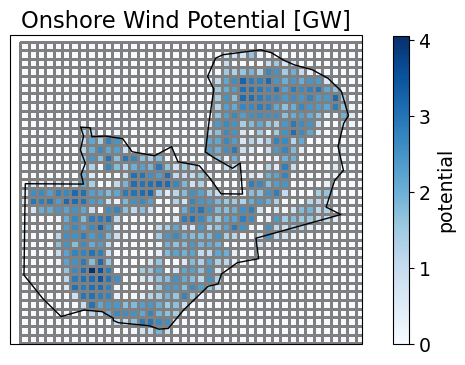

In [103]:
plot_raster(
    wind.potential,
    ["Zambia"],
    cmap="Blues",
    figsize=(8, 4),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="Onshore Wind Potential [GW]",
    # filename="rasterized-onshore-wind-potential.pdf"
)

### Solar Photovoltaic Potential [GW]

C:\Users\user\AppData\Local\Temp\ipykernel_2968\1520173435.py:29: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


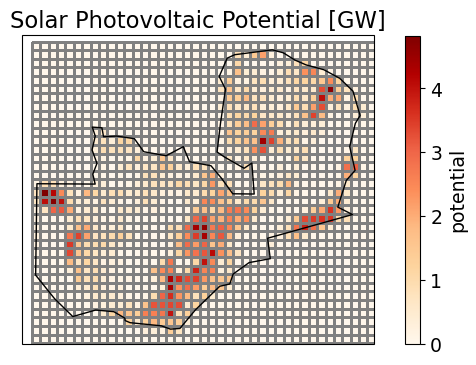

In [104]:
plot_raster(
    solar.potential,
    ["Zambia"],
    cmap="OrRd",
    figsize=(8, 4),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="Solar Photovoltaic Potential [GW]",
    # filename="rasterized-solvar-pv-potential.pdf"
)

In [105]:
def plot_map(data, cmap, projection, voronoi=None, title=None, filename=None):
    plt.rcParams.update({"font.size": 12})
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    data.plot.imshow(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, label="potential [MW]"
    )
    # contourf
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([22.6, 33.7, -18.1, -8.5])
    #, crs=ccrs.PlateCarree())  # Nigeria
    #ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa
    resource_path = "C:\\Users\\user\\Desktop\\pypsa-earth\\resources"
    if voronoi == "onshore":
        br = gpd.read_file(f"{resource_path}\\bus_regions\\regions_onshore.geojson")
        br.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            linewidth=0.25,
            edgecolor="k",
        )
    elif voronoi == "offshore":
        br = gpd.read_file(f"{resource_path}\\bus_regions\\regions_offshore.geojson")
        br.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            linewidth=0.25,
            edgecolor="k",
        )

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")


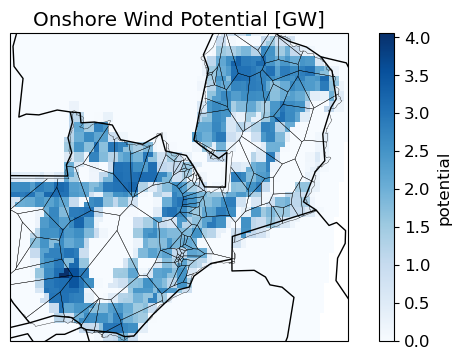

In [106]:
plot_map(
    wind.potential / 1000,
    "Blues",
    ccrs.Orthographic(),
    voronoi="onshore",
    title="Onshore Wind Potential [GW]",
    # filename="onwind-gridcell.pdf"
)


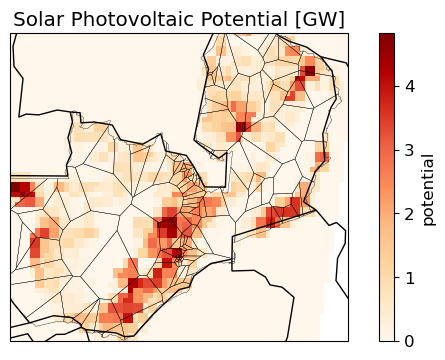

In [107]:
plot_map(
    solar.potential / 1000,
    "OrRd",
    ccrs.Orthographic(),
    voronoi="onshore",
    title="Solar Photovoltaic Potential [GW]",
    # filename="solar-gridcell.pdf",
)

### Onshore Wind Potential Density [MW/km2]

In [108]:
def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):

    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file("C:\\Users\\user\\Desktop\\pypsa-earth\\resources\\bus_regions\\regions_onshore.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([22.6, 33.7, -18.1, -8.5]) # Nigeria
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


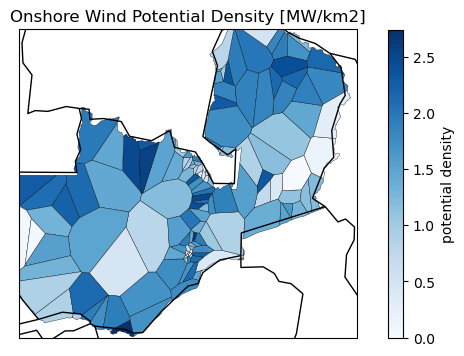

In [109]:
elec = pypsa.Network("C:\\Users\\user\\Desktop\\pypsa-earth\\networks\\elec.nc")
plot_voronoi(
    elec,
    "onwind",
    "onshore",
    "Blues",
    ccrs.Orthographic(),
    title="Onshore Wind Potential Density [MW/km2]",
    # filename="onwind-cell.pdf",
)